In [370]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import RandomOverSampler
pd.set_option('display.max_columns', None)

In [257]:
#Load All Scraped Data
user_stats = pd.read_csv("userStats.csv")
trending = pd.read_csv("trendingStats.csv", index_col=[0])
trending1718 = pd.read_csv("trendingStats-1718.csv", index_col=[0])
users_updated = pd.read_csv("users_updated.csv", index_col=[0])

users_4th = pd.read_csv('userStats5_4.csv')
trending_4th = pd.read_csv('trendingStats5_4.csv')
trending_4th.head()

,Unnamed: 0,date_run,songTitle,authorName,private,duration,album,scheduleSearchTime,numTimesUsed,artist_id,uniqueId,nickname,createTime,verified,secUid,relation,openFavorite,commentSetting,duetSetting,stitchSetting,privateAccount
0,6926430057246280453,05/04/21,Моя голова винтом,✨Мᴀᴩᴦᴏ✌🏻,False,9,NaN,0,907300,6.831978e+18,atiragram0,✨Мᴀᴩᴦᴏ✌🏻,1.590665e+09,False,MS4wLjABAAAARkTg_VBgGG8zOtB5Hg6kM_1GMbQAyUk4W2...,0.0,False,0.0,0.0,0.0,False
1,6956939305335933701,05/04/21,suono originale,Khabane lame,False,23,NaN,0,1185,1.279055e+17,khaby.lame,Khabane lame,1.470867e+09,True,MS4wLjABAAAAwAg0rSzO65WQfz4RzQgGv2Xdv108BgPXhR...,0.0,False,0.0,0.0,0.0,False
2,6945541245435381761,05/04/21,deja vu,Olivia Rodrigo,False,45,deja vu,0,1500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6840149587802475270,05/04/21,sonido original,George-G,False,8,NaN,0,1247,6.688418e+18,georgegoficial,George-G,1.557269e+09,False,MS4wLjABAAAAA2cWxfdWEksKckQBHCRMG0ikvCh961mNxf...,0.0,False,0.0,0.0,0.0,False
4,6757872491160406017,05/04/21,Teach Me How To Dougie,Classics Reborn,False,30,Teach Me How To Dougie,0,1800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
#Reformat Indices and Column Names for Consistency
users_updated.rename(columns = {'Unnamed: 0.1': 'userID'}, inplace = True)
users_updated.reset_index(drop=True, inplace=True)
trending1718.reset_index(drop=True, inplace=True)
trending.reset_index(drop=True, inplace=True)
user_stats.rename(columns = {'Unnamed: 0': 'userID'}, inplace = True)
users_4th.rename(columns = {'Unnamed: 0': 'userID'}, inplace = True)
trending_4th.rename(columns = {'Unnamed: 0': 'soundID'}, inplace = True)

users_updated.head()

,userID,soundID,date_run,followingCount,followerCount,heartCount,videoCount,diggCount,heart
0,6953076077749161222,6947333417029733126,04/29/21,163,607200,10600000,189,6759,10600000
1,6952496938612755717,6947333417029733126,04/29/21,117,1100000,26500000,155,1187,26500000
2,6956386359766420742,6947333417029733126,04/29/21,13,45300000,1000000000,679,2121,1000000000
3,6951737718888025346,6947333417029733126,04/29/21,2,418800,4700000,49,6530,4700000
4,6953055168808226054,6947333417029733126,04/29/21,455,2900000,119100000,204,11200,119100000


In [259]:
#Concatenate our two user tables
users = pd.concat([user_stats, users_updated]).drop_duplicates()
users_29 = users[users['date_run'] == '04/29/21']
users_30 = users[users['date_run'] == '04/30/21']
users_29.head()

,userID,soundID,date_run,followingCount,followerCount,heartCount,videoCount,diggCount,heart
0,6953076077749161222,6947333417029733126,04/29/21,163,607200,10600000,189,6759,10600000
1,6952496938612755717,6947333417029733126,04/29/21,117,1100000,26500000,155,1187,26500000
2,6956386359766420742,6947333417029733126,04/29/21,13,45300000,1000000000,679,2121,1000000000
3,6951737718888025346,6947333417029733126,04/29/21,2,418800,4700000,49,6530,4700000
4,6953055168808226054,6947333417029733126,04/29/21,455,2900000,119100000,204,11200,119100000


In [260]:
#Get mean song data by user statistic
song_data_agg_29 = users_29.groupby(by=["soundID"]).mean()
song_data_agg_30 = users_30.groupby(by=["soundID"]).mean()
song_data_agg_4 = users_4th.groupby(by=["soundID"]).mean()

song_data_agg_29.head()

,userID,followingCount,followerCount,heartCount,videoCount,diggCount,heart
soundID,,,,,,,
37696,6.837558e+18,980.090,359312.595,9.207480e+06,422.975,17265.790,9.207480e+06
118053679,6.846653e+18,511.705,1636966.990,5.334481e+07,387.040,10901.685,5.334481e+07
158840031,6.826014e+18,474.555,252015.535,6.184097e+06,443.345,12472.935,6.184097e+06
153013783613878272,6.864727e+18,1787.285,11544.580,1.825210e+05,202.750,12240.250,1.825210e+05
222450775220682752,6.840913e+18,504.020,363976.810,8.794654e+06,445.860,23047.290,8.794654e+06


In [261]:
def data_reformatter(df, columns_list):
    def binary_converter(col):
        convert = []
        for x in np.arange(len(col)):
            if col[x] == True:
                convert.append(1)
            else:
                convert.append(0)
        return convert
    for x in columns_list:
        df[x] = binary_converter(list(df[x]))
    return df

trending1718f = data_reformatter(trending1718, ['private', 'verified', 'openFavorite', 'privateAccount']).drop(columns = ['songTitle', 'uniqueId', 'nickname','authorName', 'album', 'secUid'])
trending_4ths = data_reformatter(trending_4th, ['private', 'verified', 'openFavorite', 'privateAccount']).drop(columns = ['songTitle', 'uniqueId', 'nickname','authorName', 'album', 'secUid'])


trending1718f['privateAccount'].unique()

array([0, 1])

In [262]:
artist_avg = pd.DataFrame(trending1718f.groupby(by = ['artist_id']).mean()['numTimesUsed'])
artist_avg_4th = pd.DataFrame(trending_4ths.groupby(by = ['artist_id']).mean()['numTimesUsed'])

artist_avg = artist_avg.rename(columns = {'numTimesUsed': 'artistAvgPlays'})
artist_avg_4th = artist_avg_4th.rename(columns = {'numTimesUsed': 'artistAvgPlays'})

trending1718a = pd.merge(trending1718f, artist_avg, left_on = 'artist_id', right_on = 'artist_id', how = 'left').drop(columns = ['artist_id'])
trending_4thf = pd.merge(trending_4ths, artist_avg_4th, left_on = 'artist_id', right_on = 'artist_id', how = 'left').drop(columns = ['artist_id', 'date_run'])


trending1718a.head()


,soundID,date_run,private,duration,scheduleSearchTime,numTimesUsed,createTime,verified,relation,openFavorite,commentSetting,duetSetting,stitchSetting,privateAccount,artistAvgPlays
0,6947333417029733126,04/29/21,0,18,0,1700000,1.470925e+09,0,0.0,0,0.0,0.0,0.0,0,1.175767e+06
1,6853737142045231878,04/29/21,0,9,0,79900,1.571554e+09,0,0.0,0,0.0,0.0,0.0,0,7.990000e+04
2,6947428005501668101,04/29/21,0,8,0,627200,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN
3,6418356150286158594,04/29/21,0,39,0,202100,1.584992e+09,1,0.0,0,3.0,0.0,0.0,0,2.021500e+05
4,6956564930254457606,04/29/21,0,16,0,418,1.470867e+09,1,0.0,0,0.0,0.0,0.0,0,1.685529e+03


In [263]:
trending_29 = trending1718a[trending1718a['date_run'] == '04/29/21'].drop(columns = ['date_run'])
trending_30 = trending1718a[trending1718a['date_run'] == '04/30/21'].drop(columns = ['date_run'])


train_29th = pd.merge(song_data_agg_29, trending_29, left_on = 'soundID', right_on = 'soundID', how='left').drop_duplicates(subset = 'soundID').drop(columns = 'userID')
test_30th = pd.merge(song_data_agg_30, trending_30, left_on = 'soundID', right_on = 'soundID', how='left').drop_duplicates(subset = 'soundID').drop(columns = 'userID').replace([np.inf, -np.inf], np.nan).dropna(axis=0)
fourth = pd.merge(song_data_agg_4, trending_4thf, left_on = 'soundID', right_on = 'soundID', how='left').drop_duplicates(subset = 'soundID').drop(columns = 'userID').replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_29th.head()



,soundID,followingCount,followerCount,heartCount,videoCount,diggCount,heart,private,duration,scheduleSearchTime,numTimesUsed,createTime,verified,relation,openFavorite,commentSetting,duetSetting,stitchSetting,privateAccount,artistAvgPlays
0,37696,980.090,359312.595,9.207480e+06,422.975,17265.790,9.207480e+06,0,30,0,40900,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN
1,118053679,511.705,1636966.990,5.334481e+07,387.040,10901.685,5.334481e+07,0,30,0,392500,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN
2,158840031,474.555,252015.535,6.184097e+06,443.345,12472.935,6.184097e+06,0,29,0,8295,1.575492e+09,1,0.0,0,0.0,0.0,0.0,0,8303.0
3,153013783613878272,1787.285,11544.580,1.825210e+05,202.750,12240.250,1.825210e+05,0,30,0,906,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN
4,222450775220682752,504.020,363976.810,8.794654e+06,445.860,23047.290,8.794654e+06,0,30,0,42000,1.471580e+09,1,0.0,0,0.0,0.0,0.0,0,42000.0


In [264]:
top25_29 = train_29th.sort_values(by = 'numTimesUsed', ascending = False).reset_index().loc[:,["soundID", "numTimesUsed"]][0:25]
top25_30 = test_30th.sort_values(by = 'numTimesUsed', ascending = False).reset_index().loc[:,["soundID", "numTimesUsed"]][0:25]
top_25_4 = fourth.sort_values(by = 'numTimesUsed', ascending = False).reset_index().loc[:,["soundID", "numTimesUsed"]][0:25]
top25_29.head()

,soundID,numTimesUsed
0,6800996740322297858,24000000
1,6857275312967796738,14700000
2,6586947002464996102,14600000
3,6791619226181306369,13500000
4,6842582526297393154,11400000


In [265]:
#Verify that the top 25 for the 29th and 30th are quite distinct from one another
similar = []
for x in list(top25_29):
    if x in list(top25_30):
        similar.append(1)
    else:
        similar.append(0)
        
        
#Since there are only two songs that overlap in these days out of the top 25, it's okay to use the 29th as train and 
#30th as test
sum(similar)

2

In [266]:
top_25_29th = []
for x in list(train_29th['soundID']):
    if x in list(top25_29['soundID']):
        top_25_29th.append(1)
    else:
        top_25_29th.append(0)

top_25_30th = []
for x in list(test_30th['soundID']):
    if x in list(top25_30['soundID']):
        top_25_30th.append(1)
    else:
        top_25_30th.append(0)

top_25_4th = []
for x in list(fourth['soundID']):
    if x in list(top_25_4['soundID']):
        top_25_4th.append(1)
    else:
        top_25_4th.append(0)

sum(top_25_30th)

25

In [267]:
train_29th['top25'] = top_25_29th
test_30th['top25'] = top_25_30th
fourth['top25'] = top_25_4th

train_29th = train_29th.drop(columns = ['numTimesUsed'])
test_30th = test_30th.drop(columns = ['numTimesUsed'])
fourth = fourth.drop(columns = ['numTimesUsed'])

train_29th.head()

,soundID,followingCount,followerCount,heartCount,videoCount,diggCount,heart,private,duration,scheduleSearchTime,createTime,verified,relation,openFavorite,commentSetting,duetSetting,stitchSetting,privateAccount,artistAvgPlays,top25
0,37696,980.090,359312.595,9.207480e+06,422.975,17265.790,9.207480e+06,0,30,0,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,0
1,118053679,511.705,1636966.990,5.334481e+07,387.040,10901.685,5.334481e+07,0,30,0,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,0
2,158840031,474.555,252015.535,6.184097e+06,443.345,12472.935,6.184097e+06,0,29,0,1.575492e+09,1,0.0,0,0.0,0.0,0.0,0,8303.0,0
3,153013783613878272,1787.285,11544.580,1.825210e+05,202.750,12240.250,1.825210e+05,0,30,0,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,0
4,222450775220682752,504.020,363976.810,8.794654e+06,445.860,23047.290,8.794654e+06,0,30,0,1.471580e+09,1,0.0,0,0.0,0.0,0.0,0,42000.0,0


In [268]:
#See if there's any deviance in average stats between top songs and not top songs in training set
train_29th_top_25 = train_29th[train_29th['top25'] == 1]
train_29th_not_25 = train_29th[train_29th['top25'] == 0]

train_29th_top_25.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))).drop(columns = ['soundID', 'top25'])

,followingCount,followerCount,heartCount,videoCount,diggCount,heart,private,duration,scheduleSearchTime,createTime,verified,relation,openFavorite,commentSetting,duetSetting,stitchSetting,privateAccount,artistAvgPlays
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,18.000000,25.000000,18.000000,25.000000,18.000000,18.000000,18.000000,25.000000,18.000000
mean,481.871600,5019598.257400,133299180.520000,524.735400,13281.972400,170124100.520000,0.000000,47.320000,0.000000,1566716980.000000,0.560000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,6054733.537037
std,171.301201,2620586.597350,59949940.153053,112.619519,7280.686805,144594687.675983,0.000000,30.362696,0.000000,21046752.017440,0.506623,0.000000,0.000000,0.000000,0.000000,0.235702,0.000000,1512494.481002
min,170.835000,1301581.020000,33230104.000000,342.295000,3810.610000,33230104.000000,0.000000,10.000000,0.000000,1515951349.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3594766.666667
25%,383.390000,3365115.995000,85846500.000000,433.325000,9971.985000,108846500.000000,0.000000,30.000000,0.000000,1558417632.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5300000.000000
50%,475.820000,4986643.900000,130368516.000000,531.115000,11548.950000,141368516.000000,0.000000,48.000000,0.000000,1570917490.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5695383.333333
75%,554.445000,5699672.500000,158095000.000000,579.930000,14477.485000,168209180.000000,0.000000,60.000000,0.000000,1580439903.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6350060.250000
max,975.470000,15035555.755000,289498725.500000,754.695000,42405.880000,784208725.500000,0.000000,166.000000,0.000000,1594920791.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10226140.000000


In [269]:
train_29th_not_25.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))).drop(columns = ['soundID', 'top25'])

,followingCount,followerCount,heartCount,videoCount,diggCount,heart,private,duration,scheduleSearchTime,createTime,verified,relation,openFavorite,commentSetting,duetSetting,stitchSetting,privateAccount,artistAvgPlays
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,374.000000,614.000000,374.000000,614.000000,374.000000,374.000000,374.000000,614.000000,374.000000
mean,864.638853,1137462.854232,35645926.486519,498.892005,16330.551606,40276399.662660,0.000000,40.091205,0.000000,1554050833.240642,0.280130,0.000000,0.000000,0.008021,0.122995,0.109626,0.004886,383960.156977
std,607.567530,1357039.254676,45005660.255641,266.657496,8922.155117,54223856.751638,0.000000,37.016395,0.000000,43113646.372130,0.449429,0.000000,0.000000,0.155126,0.548804,0.524226,0.069786,927436.842752
min,13.000000,574.000000,3224.181818,49.000000,63.000000,3224.181818,0.000000,5.000000,0.000000,1442607048.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,451.093750,206119.110000,4043681.437500,355.438750,10027.031250,4043681.437500,0.000000,16.000000,0.000000,1541507892.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,612.426667
50%,621.377500,660109.861285,17737955.500000,464.298485,14484.656543,18577936.250000,0.000000,30.000000,0.000000,1564046472.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32075.000000
75%,1110.042500,1630977.286250,53294209.875000,596.407500,20777.965000,57307454.375000,0.000000,59.750000,0.000000,1584660660.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,325429.166667
max,4121.666667,9877157.465000,316556770.500000,4429.245000,81069.100000,420333599.500000,0.000000,272.000000,0.000000,1619086643.000000,1.000000,0.000000,0.000000,3.000000,3.000000,3.000000,1.000000,10226140.000000


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


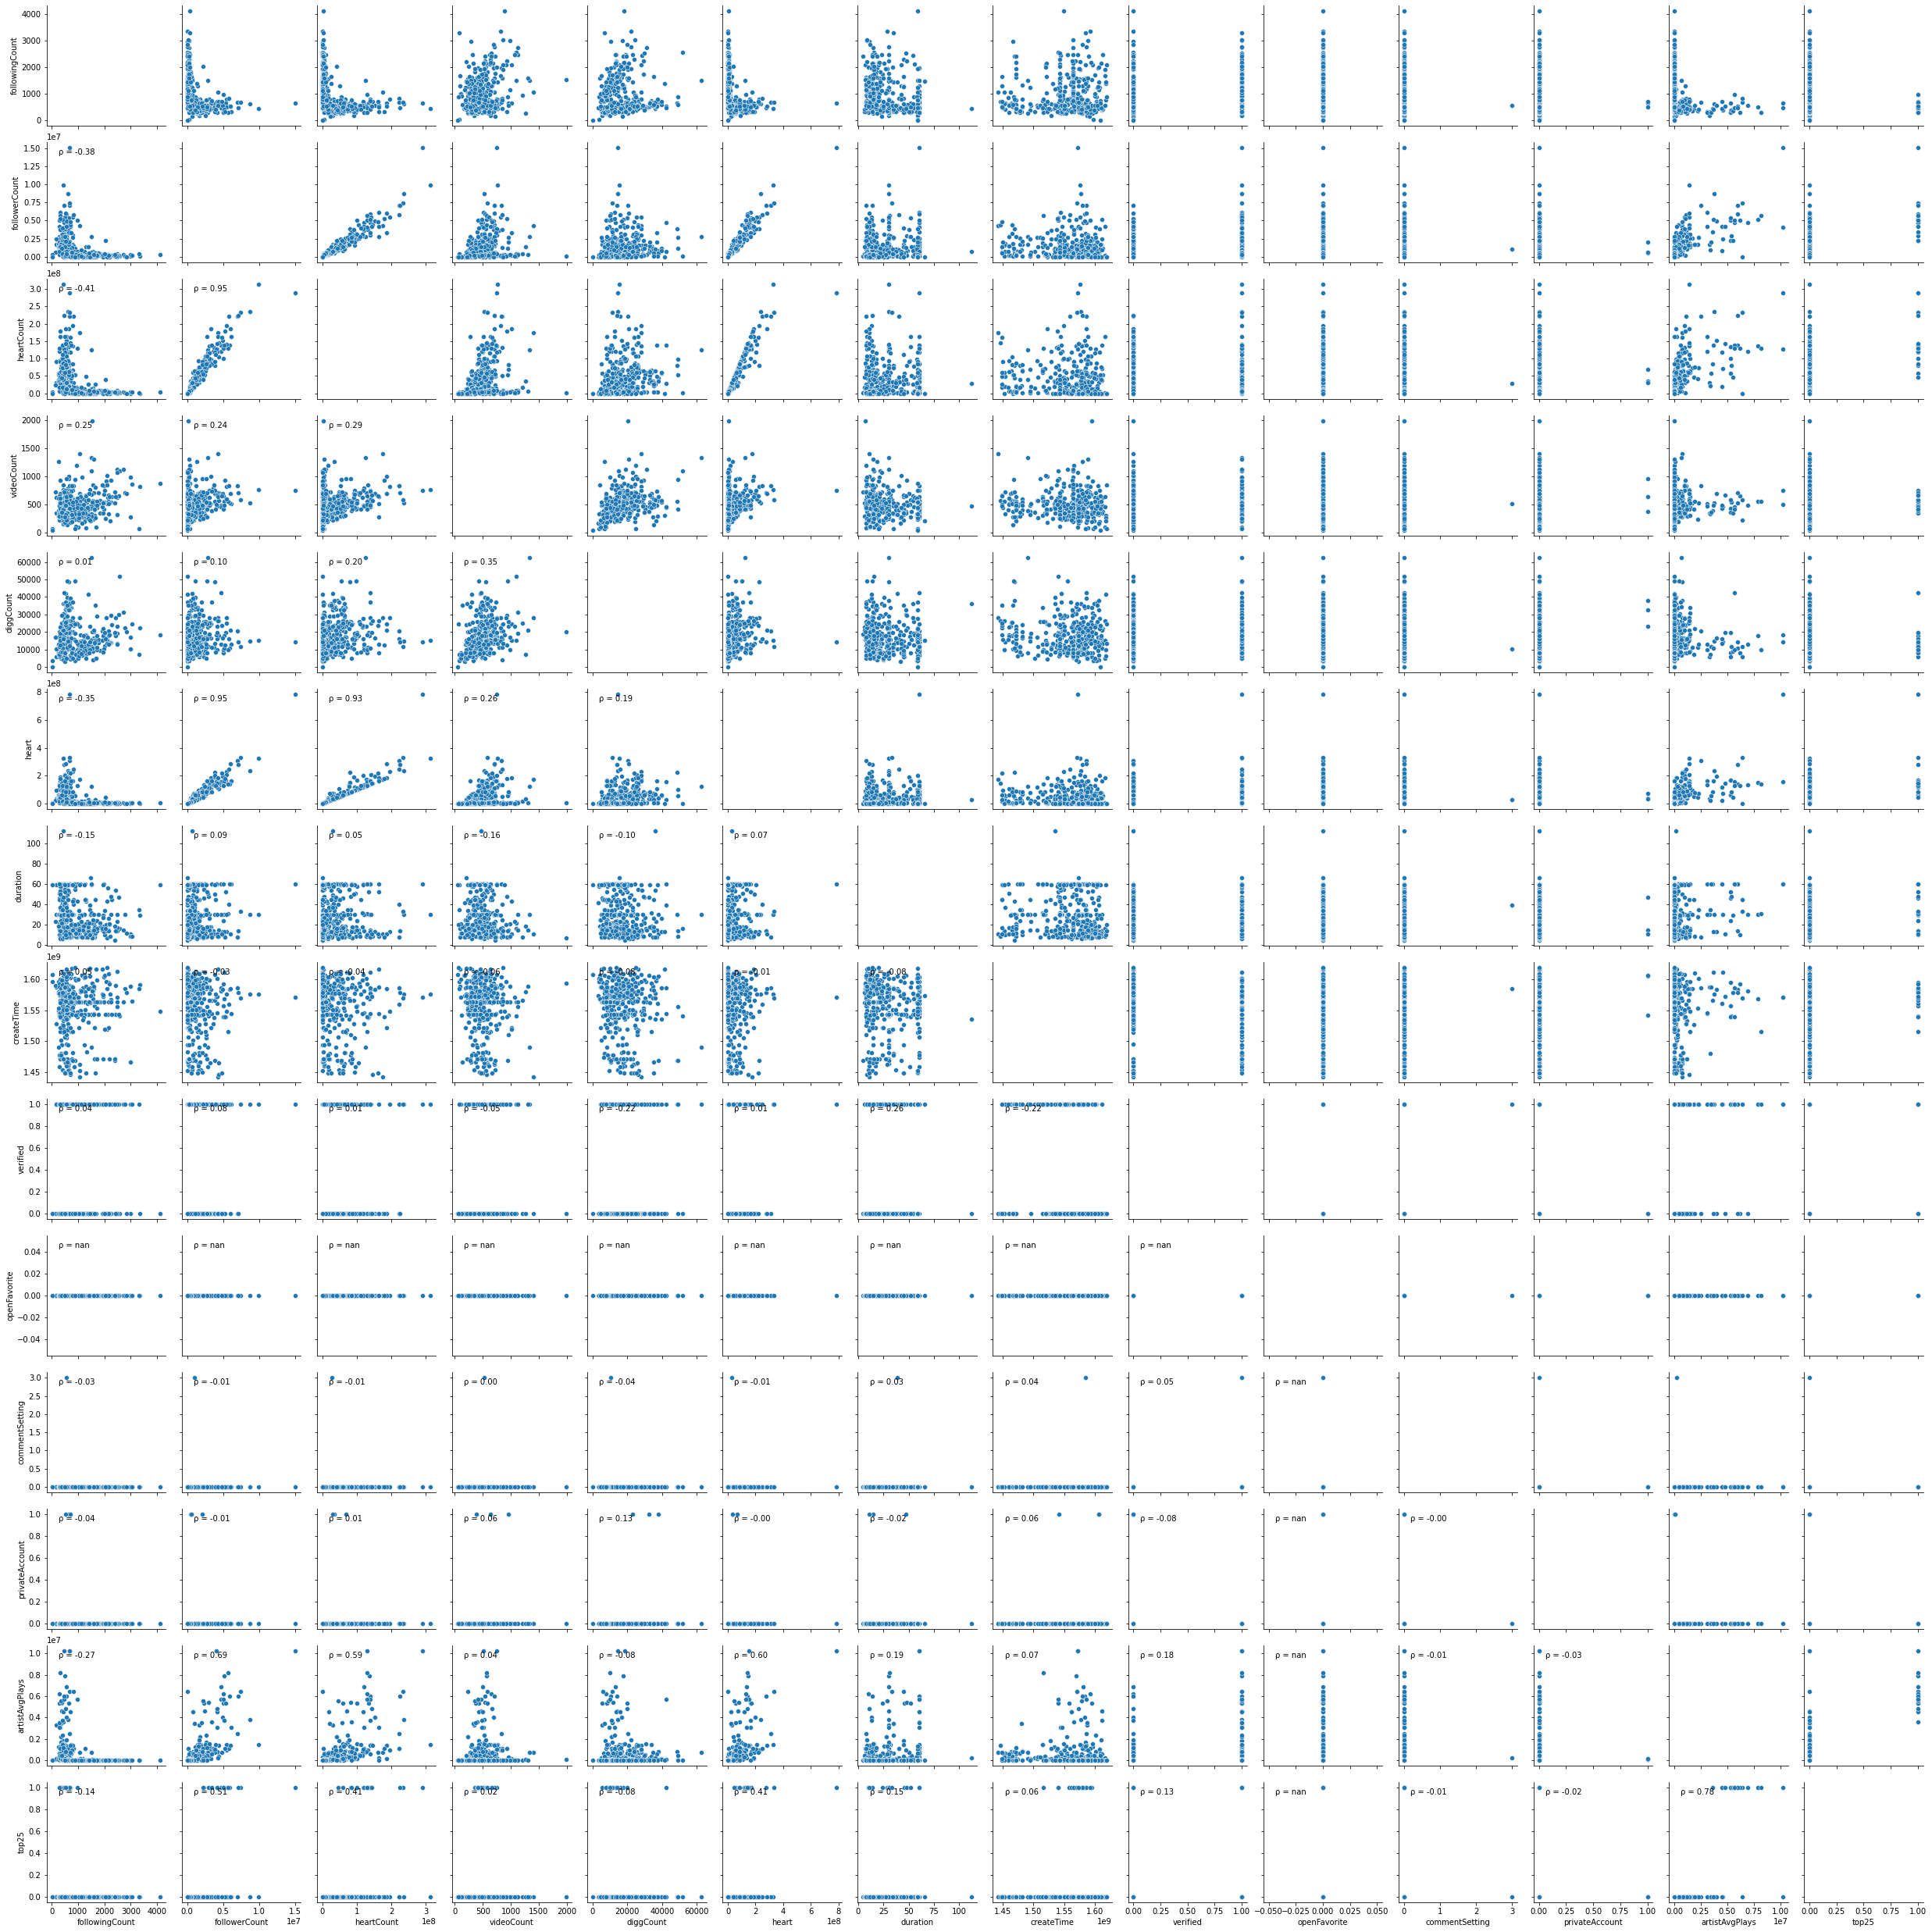

In [225]:
#Visualize our training set with pairplots and correlations between features
def pairplotter_with_corr(dataset):
    def correlation_plot(x, y, ax=None, **kws):
        r, _ = pearsonr(x, y)
        ax = ax or plt.gca()
        ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    pairplot = sns.pairplot(dataset, diag_kind = 'scatter')
    pairplot.map_lower(correlation_plot)
    plt.show()

#Drop irrelevant columns from above analysis
irr_cols = ['private', 'scheduleSearchTime', 'relation', 'stitchSetting', 'duetSetting', 'soundID']
train_visualizer = train_29th.copy().drop(columns = irr_cols)
train_vis = train_visualizer.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
pairplotter_with_corr(train_vis)


In [336]:
#Drop all irrelevant columns
#This includes both the columns we deemed irrelevant before and features with lower than 0.03 correlation with top25
irrelevant = ['private', 'scheduleSearchTime', 'relation', 'stitchSetting', 'duetSetting', 'followingCount', 'videoCount', 'diggCount', 'openFavorite', 'commentSetting', 'privateAccount']
train_final = train_29th.drop(columns = irrelevant).replace([np.inf, -np.inf], np.nan).dropna(axis=0)
test_final = test_30th.drop(columns = irrelevant).replace([np.inf, -np.inf], np.nan).dropna(axis=0)
fourth_final = fourth.drop(columns = irrelevant).replace([np.inf, -np.inf], np.nan).dropna(axis=0)

train_y = train_final['top25']
train_x = train_final.drop(columns = ['top25'])

test_y = test_final['top25']
test_x = test_final.drop(columns = ['top25'])

fourth_y = fourth_final['top25']
fourth_x = fourth_final.drop(columns = ['top25'])

sum(train_y)

18

In [337]:
#Since our data is way too unbalanced, we must sample bootstrap from the training set in order to more accurately train

#Use imblearn to resample our data
ros = RandomOverSampler(random_state=42)

train_x1, train_y1 = ros.fit_resample(train_x, train_y)


In [ ]:
#Cross validation for our ccp_alpha parameter
grid_values = {'ccp_alpha': np.linspace(0, 0.01, 61),
               'min_samples_leaf': [10],
               'min_samples_split': [20],
               'max_depth': [100],
               'random_state': [2]} 
dtr = RandomForestClassifier()
best_ccps = []

#Bootstrap the optimal parameter value from different random states
for x in np.arange(300, 310):
    cv = KFold(n_splits = 5, random_state = x, shuffle = True)
    dtr_cv = GridSearchCV(dtr, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=1) 
    dtr_cv.fit(train_x, train_y)
    best_ccps.append(dtr_cv.best_params_['ccp_alpha'])
acc = dtr_cv.cv_results_['mean_test_score']
ccp = dtr_cv.cv_results_['param_ccp_alpha'].data

In [343]:
model = RandomForestClassifier(ccp_alpha = 0.05, min_samples_leaf = 10, min_samples_split = 20, max_depth = 100)
model.fit(train_x1, train_y1)
predictions = model.predict(test_x)
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [344]:
#Show confusion matrix results
confusion = confusion_matrix(test_y, predictions)
print ("Confusion Matrix: \n", confusion)

Confusion Matrix: 
 [[72  0]
 [14 11]]


In [375]:
#Calculate Precision
precision = precision_score(test_y, predictions)
precision

1.0

In [373]:
#Calculate Recall
recall = recall_score(test_y, predictions)
recall

0.44

In [374]:
#Calculate Accuracy Score
acc = accuracy_score(test_y, predictions)
acc

0.8556701030927835

In [357]:
#Calculate FPR
tnr = recall_score(test_y, predictions, pos_label = 0)
fpr = 1 - tnr
fpr

0.0

In [371]:
#Bootstrap Validation
def bootstrap_validation(test_data, test_label, model, metrics_list, sample=500, random_state=66):
    tic = time.time()
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_label,bs_predicted)
#         if bs_iter % 100 == 0:
#             print(bs_iter, time.time()-tic)
    output_df = pd.DataFrame(output_array)
    return output_df
bootstrap = bootstrap_validation(test_x, test_y, model, metrics_list = [accuracy_score, precision_score, recall_score], sample = 500)
bootstrap

(500, 3)


,0,1,2
0,0.876289,1.0,0.538462
1,0.824742,1.0,0.346154
2,0.845361,1.0,0.347826
3,0.886598,1.0,0.450000
4,0.886598,1.0,0.560000
...,...,...,...
495,0.814433,1.0,0.437500
496,0.865979,1.0,0.458333
497,0.865979,1.0,0.409091
498,0.896907,1.0,0.545455


(-0.08, 0.08)

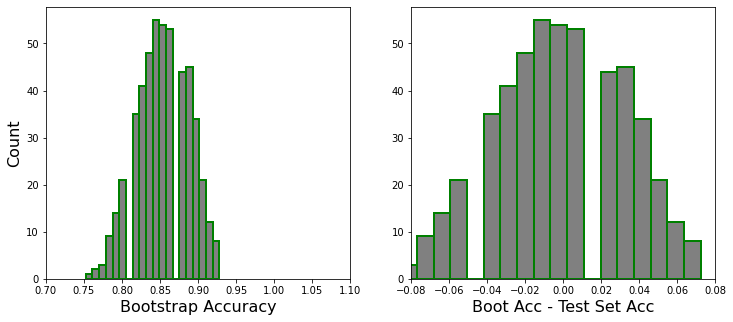

In [388]:
#Visualize our Bootstrap - Accuracy
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap Accuracy', fontsize=16)
axs[1].set_xlabel('Boot Acc - Test Set Acc', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bootstrap.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.7,1.1])
axs[1].hist(bootstrap.iloc[:,0]-acc, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.08,0.08])

(-0.03, 0.07)

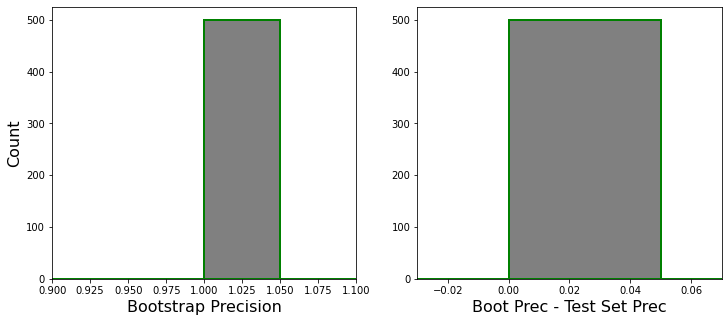

In [385]:
#Visualize our Bootstrap - Precision
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap Precision', fontsize=16)
axs[1].set_xlabel('Boot Prec - Test Set Prec', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bootstrap.iloc[:,1], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.9,1.1])
axs[1].hist(bootstrap.iloc[:,1]-precision, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.03,0.07])

(-0.3, 0.5)

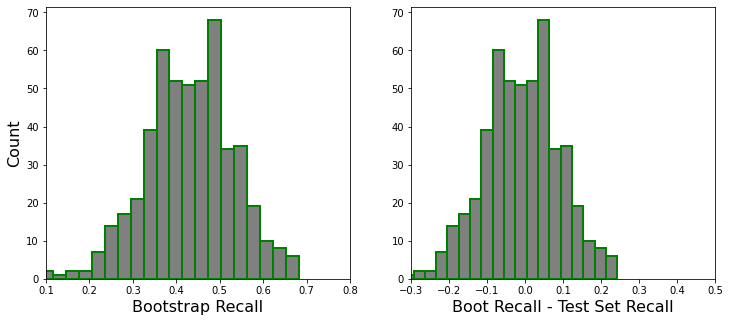

In [381]:
#Visualize our Bootstrap - Precision
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap Recall', fontsize=16)
axs[1].set_xlabel('Boot Recall - Test Set Recall', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bootstrap.iloc[:,2], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.1,0.8])
axs[1].hist(bootstrap.iloc[:,2]-recall, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.3,0.5])